Imports


In [ ]:
import os
import pickle
import pathlib
import librosa
import keras
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


# Dataset

In [ ]:
data_dir = pathlib.Path('/content/drive/My Drive/Academics/Fall 2020/Intelligent Systems/Final Project/genres')

In [ ]:
genres = np.array(tf.io.gfile.listdir(str(data_dir)))
print(genres)

['hiphop' 'rock' 'classical' 'country' 'jazz' 'pop' 'reggae' 'disco'
 'metal' 'blues']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + "/*/*")
np.random.shuffle(filenames)
print("Number of total samples: ", len(filenames))
print("Number of samples per label: ", len(tf.io.gfile.listdir(str(data_dir/genres[0]))))
print("Sample file tensor: ", filenames[0])

Number of total samples:  1000
Number of samples per label:  100
Sample file tensor:  /content/drive/My Drive/Academics/Fall 2020/Intelligent Systems/Final Project/genres/classical/classical.00081.wav


# Preprocessing

In [ ]:
def get_max_length(arr):
  max = 0
  for i in arr:
    if len(i) > max:
      max = len(i)
  return max
#MAX_LENGTH = get_max_length(X)

In [ ]:
train_data_size = 500

In [ ]:
INPUT_SHAPE = (train_data_size, 1025, 1320)
MAX_LENGTH = 675808

In [ ]:
def get_features_and_target(file_path):
  target = str(file_path).split(os.path.sep)[-2]
  audio_binary = tf.io.read_file(file_path)
  audio, _ = tf.audio.decode_wav(audio_binary)
  features = np.array(audio).reshape(len(audio))
  return features, target

In [ ]:
def equal_length(waveform):
  zero_padding = np.zeros(MAX_LENGTH - np.shape(waveform)[0], dtype=np.float32)
  waveform = np.asarray(waveform, np.float32)
  equal_length = np.concatenate((waveform, zero_padding), 0)
  return equal_length

In [ ]:
def get_data(filenames):
  X = np.zeros(INPUT_SHAPE)
  Y = []
  i = 0
  for f_name in filenames:
    features, target = get_features_and_target(f_name)
    X[i] = librosa.amplitude_to_db(np.abs(librosa.stft( np.array(equal_length(features), dtype=np.float32))))
    Y.append(target)
    i += 1
    print(i)
  return X, np.array(Y)

In [ ]:
X, Y = get_data(filenames[:train_data_size])

In [ ]:
y_encoder = LabelEncoder()
y_encoder.fit(Y)

LabelEncoder()

In [ ]:
Y = y_encoder.transform(Y)

In [ ]:
#variables_path = '/content/drive/MyDrive/Academics/Fall 2020/Intelligent Systems/Final Project/Variables/'
#with open(variables_path + 'y_encoder1.pkl', 'wb') as f:
#  pickle.dump(y_encoder, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
X = X / np.max(np.abs(X))

# Spectrogram

In [ ]:
tmp = y_encoder.inverse_transform(Y[:100])
spec_ix = []
for genre in genres:
  spec_ix.append(np.where(tmp == genre)[0][0])

In [ ]:
spec_ix

[31, 8, 6, 1, 0, 4, 9, 2, 22, 3]

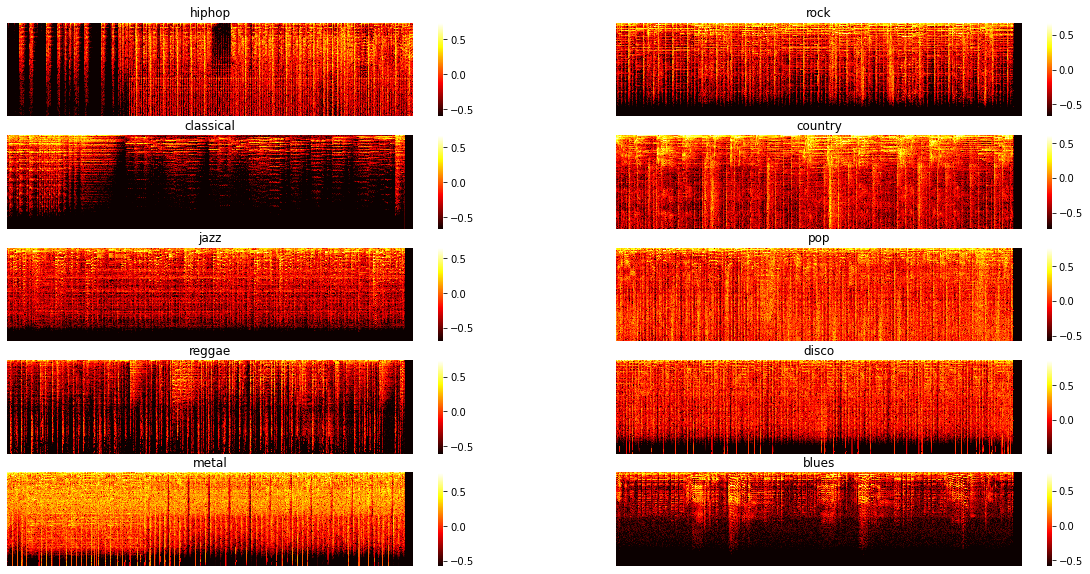

In [ ]:
k = 0
fig, ax = plt.subplots(5, 2, figsize=(20, 10))

for i in range(5):
  for j in range(2):
    sns.heatmap(X[spec_ix[k]], cmap='hot', ax=ax[i, j])
    ax[i, j].set_title(y_encoder.inverse_transform([Y[spec_ix[k]]])[0])
    ax[i, j].axis('off')
    k += 1
plt.show()

# Fully Connected Model

In [ ]:
def FullyConnected():
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=INPUT_SHAPE[1:]))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=10, activation='softmax'))

  return model

In [ ]:
model = FullyConnected()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1353000)           0         
_________________________________________________________________
dense (Dense)                (None, 512)               692736512 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5

# 1D-CNN Model

In [ ]:
def CNN1D():
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=INPUT_SHAPE[1:]))

  model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  model.add(keras.layers.Dense(units=10, activation='softmax'))

  return model

In [ ]:
model = CNN1D()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1025, 16)          63376     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1025, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 32)           1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 32)           0

# 2D-CNN Model

In [ ]:
def CNN2D():

  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(INPUT_SHAPE[1], INPUT_SHAPE[2], 1)))
  model.add(keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(20, activation='relu', kernel_initializer=keras.initializers.HeNormal()))
  model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer=keras.initializers.HeNormal()))

  return model

In [ ]:
X = X.reshape(((INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], 1)))
model = CNN2D()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1021, 1316, 10)    260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 510, 658, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 506, 654, 10)      2510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 253, 327, 10)      0         
_________________________________________________________________
flatten (Flatten)            (None, 827310)            0         
_________________________________________________________________
dense (Dense)                (None, 20)                16546220  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

# RCNN Model

In [ ]:
def RCNN():
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=INPUT_SHAPE[1:]))

  model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
  model.add(keras.layers.MaxPooling1D(pool_size=2))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.LSTM(96))
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax'))

  return model

In [ ]:
model = RCNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1025, 16)          63376     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1025, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 512, 16)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 16)           64        
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 32)           1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 32)           3

# Training

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, Y, epochs=50, validation_split=0.2)

Text(0.5, 1.0, '2D-CNN')

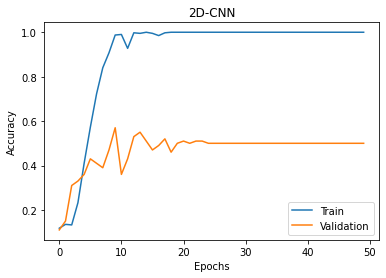

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('2D-CNN')

In [ ]:
model.save('/content/drive/MyDrive/Academics/Fall 2020/Intelligent Systems/Final Project/Models/CNN2D.h5')

# Testing

In [ ]:
test_data_size = 300

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/Academics/Fall 2020/Intelligent Systems/Final Project/Models/FullyConnected.h5')

In [ ]:
def prediction(filename):
  features, target = get_features_and_target(filename)
  features = librosa.amplitude_to_db(np.abs(librosa.stft( np.array(equal_length(features), dtype=np.float32)))) / 56
  #features = features.reshape((1, INPUT_SHAPE[1], INPUT_SHAPE[2], 1)) # FOR 2D-CNN
  features = features.reshape((1, features.shape[0], features.shape[1])) # FOR REST
  pred = y_encoder.inverse_transform([np.argmax(model.predict(features))])
  return pred[0], target

In [ ]:
confusion_matrix = np.zeros((10, 10))
for i in range(train_data_size, train_data_size+test_data_size):
  print(i)
  y_test, y_true = prediction(filenames[i])
  y_test = y_encoder.transform([y_test])
  y_true = y_encoder.transform([y_true])
  confusion_matrix[y_test, y_true] += 1

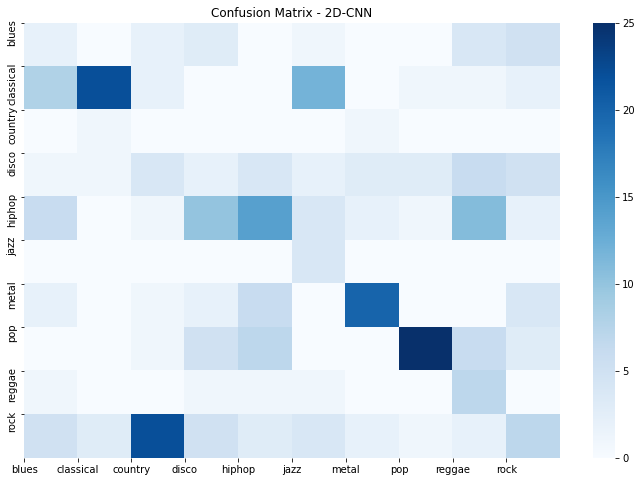

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix - 2D-CNN')
plt.xticks(ticks=range(0, 10), labels=y_encoder.inverse_transform(range(0, 10)))
plt.yticks(ticks=range(0, 10), labels=y_encoder.inverse_transform(range(0, 10)))
plt.show()